## Segmentation multi-organes en IRM abdominale </font></br></div>

P.-H. Conze <span style="color:blue">pierre-henri.conze@imt-atlantique.fr</span> - 
F. Rousseau <span style="color:blue">francois.rousseau@imt-atlantique.fr</span>

L'objectif de ce projet est de développer un **modèle de segmentation multi-organes** (foie, reins et rate) à partir d'images IRM T2 abdominales. 

**Données** (22,8Mo) : https://www.dropbox.com/s/ybi55d0u7bgijqf/chaos.zip?dl=0

Vous disposez de **12 examens** (à charger dans la session Colab), 8 pour l'apprentissage et 4 pour le test ! 


# Imports

In [43]:
import nibabel
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.restoration import denoise_tv_bregman
from scipy.ndimage import gaussian_filter
from scipy.ndimage import shift
from sklearn.cluster import KMeans
from scipy import linalg
from scipy.special import logsumexp

# Load data

La fonction `read_train_exam(exam_nb)` fournie ci-dessous permets de lire pour un examen d'apprentissage d'indice `exam_nb` :
- l'image acquise en modalité T2
- un masque de segmentation vérité-terrain (1 : foie, 2 : rein droit, 3 : rein gauche, 4 : rate)

La fonction `read_test_exam(exam_nb)` permets de lire l'image T2 correspondant à l'examen de test d'indice `exam_nb`.

In [44]:
def read_train_exam(exam_nb):
    image = nibabel.load('%02d-T2SPIR-src.nii.gz'%(exam_nb))
    mask = nibabel.load('%02d-T2SPIR-mask.nii.gz'%(exam_nb))
    return image, mask

def read_test_exam(exam_nb):
    image = nibabel.load('%02d-T2SPIR-src.nii.gz'%(exam_nb))
    return image

Les examens 1, 2, 3, 5, 8, 10, 13 et 19 serviront d'examens d'apprentissage tandis que les examens 21, 22, 32 et 39 serviront d'examens de test. Les masques associés aux examens d'apprentissage sont fournis. Les masques associés aux examens de test seront fournis à la fin du projet (début de séance 10), pour évaluation.

In [45]:
train_ids = [1,2,3,5,8,10,13,19]
test_ids = [21,22,32,39]

# Data exploration

In [46]:
plt.rc('font', size=15) 

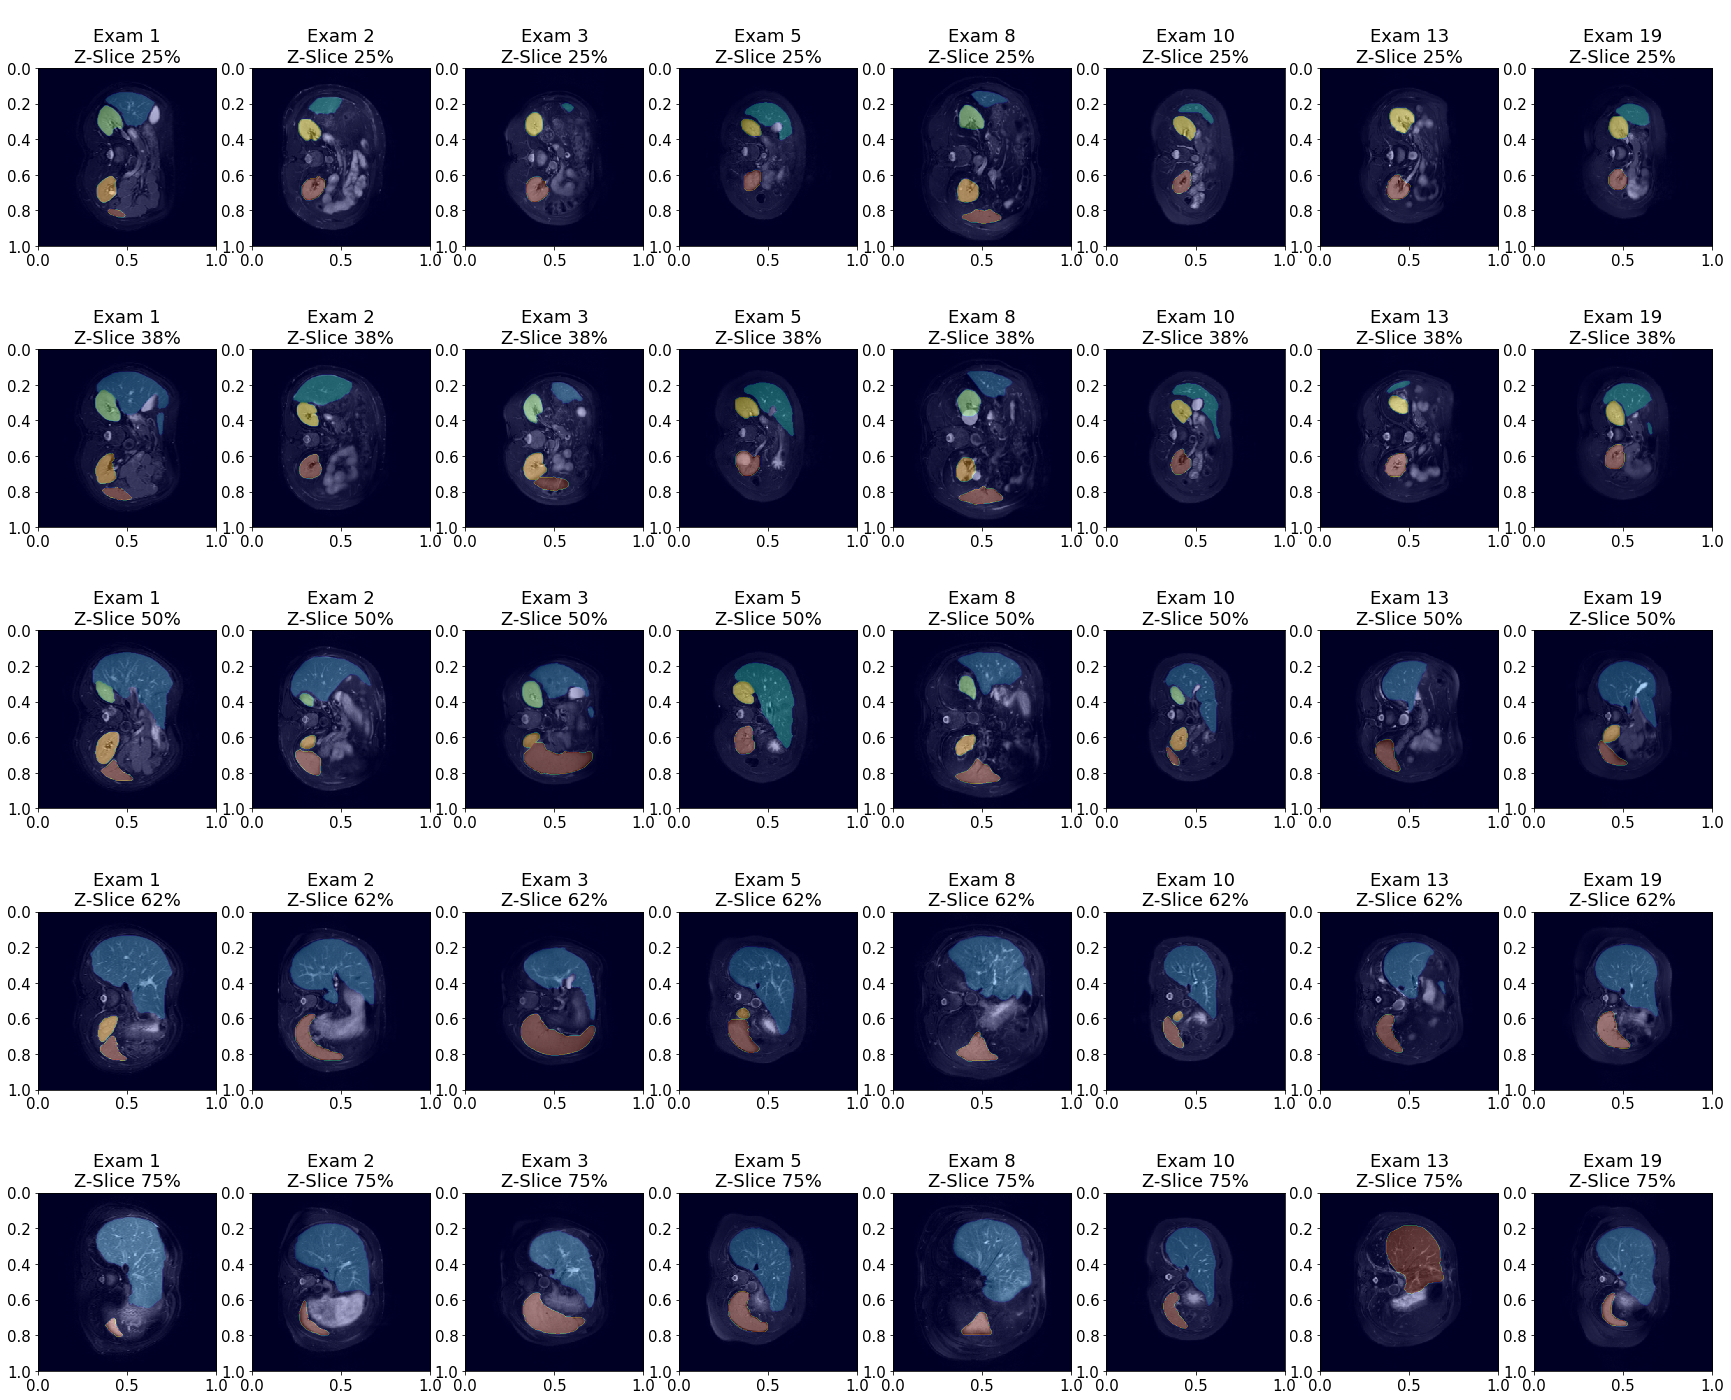

In [47]:
RNG_MIN = 0.25
RNG_FACTOR = 0.125
RNG_MAX = 0.75 + RNG_FACTOR
FACTOR_RNG = np.arange(RNG_MIN,RNG_MAX,RNG_FACTOR)

all_img_slices, all_mask_slices = [], []
for train_id in train_ids:
    image, mask = read_train_exam(train_id)
    a = np.unique(np.where(mask.get_fdata()>0.)[2])
    img_slices = []
    mask_slices = [] 
    for factor in FACTOR_RNG:
        idx = int(1*len(a)*factor)
        idx = -1 if idx >= len(a) else idx
        z_slice = a[idx]
        img_slices.append(resize(image.get_fdata()[:,:,z_slice],(256,256),mode='reflect',anti_aliasing=True))
        mask_slices.append(resize(mask.get_fdata()[:,:,z_slice],(256,256),mode='reflect',anti_aliasing=True))
    all_img_slices.append(img_slices)
    all_mask_slices.append(mask_slices)

fig, axs = plt.subplots(len(FACTOR_RNG), len(train_ids), figsize=(30,25))
for i in range(len(train_ids)):
    img_slices = all_img_slices[i]
    mask_slices = all_mask_slices[i] 
    for j in range(len(FACTOR_RNG)):
        axs[j, i].set_title('\nExam {}\nZ-Slice {:.0f}%'.format(train_ids[i], FACTOR_RNG[j]*100))
        axs[j, i].imshow(img_slices[j], cmap='gray', interpolation='nearest', extent=[0,1,1,0]) 
        axs[j, i].imshow(mask_slices[j], cmap='jet', alpha=0.3, extent=[0,1,1,0])
plt.show()

# Features

In [48]:
AXIS_X = 0
AXIS_Y = 1
AXIS_Z = 2

In [49]:
IDX_I = 0
IDX_I_BREG = 1
IDX_X = 2
IDX_Y = 3
IDX_Z = 4

In [51]:
#Sigma 1: controler si le region 1 est un voxel ou plusieurs 
#Sigma 2 controler si le region 1 est un voxel ou plusieurs 
#(0,0,0) est comparer la region avec le voxel
def add_neighbours_intensity_diff(image_data, sigma1=0, sigma2=0, posRegion1=(0,0,0), posRegion2=None, beta=1, mode='constant'):
    gaussian1 = gaussian_filter(input=image_data, sigma=sigma1)
    shift1 = gaussian1.shape * np.array(posRegion1) * -1
    region1 = shift(input=gaussian1, shift=shift1, mode=mode)
    diff = region1
    if posRegion2 != None: 
        gaussian2 = gaussian_filter(input=image_data, sigma=sigma2)
        shift2 = gaussian2.shape * np.array(posRegion2) * -1
        region2 = shift(input=gaussian2, shift=shift2, mode=mode) 
        diff -= region2 * beta
    return diff

In [52]:
#Sigma 1: comparer une region de l'image ou un voxel independent 
#Sigma 2: comparer une region de l'image symetrique ou un voxel independent te
def add_mirror_intensity_diff(image_data,sigma1=0, sigma2=0, xMirror=False, yMirror=False, zMirror=False): 
    gaussian1 = gaussian_filter(input=image_data, sigma=sigma1)
    gaussian2 = gaussian_filter(input=image_data, sigma=sigma2)
    xStep = -1 if xMirror else 1
    yStep = -1 if yMirror else 1
    zStep = -1 if zMirror else 1
    mirror_data = gaussian2[::xStep, ::yStep, ::zStep]
    diff = gaussian1 - mirror_data
    return diff

#Bayesian approach
def init_variable(data, nb_gauss):
    means = KMeans(n_clusters=nb_gauss, random_state=None).fit(data).cluster_centers_
    cv = np.cov(data.T) + 1e-3 * np.eye(data.shape[1])
    covariances = np.tile(cv, (nb_gauss, 1, 1))
    priors = np.tile(1.0 / nb_gauss, nb_gauss)
    return (means, covariances, priors)

def log_multivariate_normal_density(X, means, covars, min_covar=1.e-7):

    n_samples, n_dim = X.shape
    nmix = len(means)
    log_prob = np.empty((n_samples, nmix))
    for c, (mu, cv) in enumerate(zip(means, covars)):
        try:
            cv_chol = linalg.cholesky(cv, lower=True)
        except linalg.LinAlgError:
            cv_chol = linalg.cholesky(cv + min_covar * np.eye(n_dim),
                                      lower=True)
        cv_log_det = 2 * np.sum(np.log(np.diagonal(cv_chol)))
        cv_sol = linalg.solve_triangular(cv_chol, (X - mu).T, lower=True).T
        log_prob[:, c] = - .5 * (np.sum(cv_sol ** 2, axis=1) +
                        n_dim * np.log(2 * np.pi) + cv_log_det)
        
    return log_prob

def score_samples(data,means,covariances,priors):

    lpr = (log_multivariate_normal_density(data, means, covariances) + np.log(priors))
    logprob = logsumexp(lpr, axis=1)
    responsibilities = np.exp(lpr - logprob[:, np.newaxis])
    return logprob, responsibilities

def maximization_step(data,responsibilities):
  nb_gauss = responsibilities.shape[1]
  nb_channels = data.shape[1]
  nb_pixels = data.shape[0]
  priors = np.zeros((nb_gauss,1))
  means = np.zeros((nb_gauss,nb_channels))
  covariances = np.zeros((nb_gauss,nb_channels,nb_channels))

  vecN = np.sum(responsibilities,axis=0)
  priors = vecN/np.sum(vecN)

  for k in range(nb_gauss):
      means[k,:]  = np.dot(responsibilities[:,k],data) / vecN[k]
      for i in range(nb_pixels):
          tmpDiff = (data[i,:]-means[k,:]).reshape(nb_channels,1)
          covariances[k,:,:] += responsibilities[i,k] * np.dot(tmpDiff,tmpDiff.T) 
      covariances[k,:,:] /= vecN[k]
  
  return (means,covariances,priors)  

def EM(data,nb_gauss):
  cost = [] # fonction de coût
  current_log_likelihood = None
  tol = 1e-3 # seuil de convergence vis-à-vis de de la différence entre log vraisemblance courante et précédente
  nbiter = 100 # nombre d'itérations
  (means, covariances, priors) = init_variable(data, nb_gauss)
  for i in range(nbiter):
      prev_log_likelihood = current_log_likelihood
      # E step
      log_likelihoods, responsibilities = score_samples(data, means, covariances, priors)
      current_log_likelihood = log_likelihoods.mean()
      cost.append(current_log_likelihood)
      if prev_log_likelihood is not None:
          change = abs(current_log_likelihood - prev_log_likelihood)
          print('\t\tLog likelihood: ' + str(current_log_likelihood))
          print('\t\tChange: ' + str(change))
          if change < tol:
              print('\t\tEM algorithm converged.')
              break
      # M step  
      means, covariances, priors = maximization_step(data, responsibilities) 
  return (means, covariances, priors, cost)  



In [65]:
"""
def add_bayes(image_data,nb_gauss=4):
  data=image_data[image_data>41]  #Je ne sais pas quel est l'intensite maximale possible, c'est la quantite maximale des images train
  data=data[data<927].flatten().reshape(-1,1)/2060
  (means, covariances, prior, cost) = EM(data, nb_gauss)
  image=image_data.flatten().reshape(-1,1)/2060
  logprob, responsibilities = score_samples(image, means, covariances, prior)
  seg = np.argmax(responsibilities, axis=1)
  seg = np.reshape(seg, image_data.shape)  
  return seg
"""


"\ndef add_bayes(image_data,nb_gauss=4):\n  data=image_data[image_data>41]  #Je ne sais pas quel est l'intensite maximale possible, c'est la quantite maximale des images train\n  data=data[data<927].flatten().reshape(-1,1)/2060\n  (means, covariances, prior, cost) = EM(data, nb_gauss)\n  image=image_data.flatten().reshape(-1,1)/2060\n  logprob, responsibilities = score_samples(image, means, covariances, prior)\n  seg = np.argmax(responsibilities, axis=1)\n  seg = np.reshape(seg, image_data.shape)  \n  return seg\n"

In [53]:
def exam2features(image, mask):
    vec_img = image.get_fdata().flatten()
    image_tvb = denoise_tv_bregman(image.get_fdata(),weight=1.0) 
    vec_tvb = image_tvb.flatten()
    (X,Y,Z) = np.where(np.ones(shape=image.shape,dtype=bool))
    X = np.array(X, dtype=float)/image.shape[AXIS_X]
    Y = np.array(Y, dtype=float)/image.shape[AXIS_Y]
    Z = np.array(Z, dtype=float)/image.shape[AXIS_Z]

    # Voxel Gaussian with raw intensity
    gaussian_3 = add_neighbours_intensity_diff(image.get_fdata(), sigma1=3).flatten()

    # Voxel Gaussian with Bregman intensity
    gaussian_tvb_1 = add_neighbours_intensity_diff(image_tvb, sigma1=1).flatten()
    gaussian_tvb_1_5 = add_neighbours_intensity_diff(image_tvb, sigma1=1.5).flatten()

    # Voxel immediate Neighbours difference with raw intensity (far and close)
    nb_x_neg_diff_c = add_neighbours_intensity_diff(image.get_fdata(), sigma1=0, sigma2=1,posRegion2=(-0.004,0,0)).flatten()
    nb_x_neg_diff_f = add_neighbours_intensity_diff(image.get_fdata(), sigma1=0, sigma2=1,posRegion2=(-0.01,0,0)).flatten()
    nb_x_pos_diff_f = add_neighbours_intensity_diff(image.get_fdata(), sigma1=0, sigma2=1,posRegion2=(0.01,0,0)).flatten()
    nb_x_pos_diff_c = add_neighbours_intensity_diff(image.get_fdata(), sigma1=0, sigma2=1,posRegion2=(0.004,0,0)).flatten()
    nb_y_neg_diff_c = add_neighbours_intensity_diff(image.get_fdata(), sigma1=0, sigma2=1,posRegion2=(0,-0.004,0)).flatten()
    nb_y_neg_diff_f = add_neighbours_intensity_diff(image.get_fdata(), sigma1=0, sigma2=1,posRegion2=(0,-0.01,0)).flatten()
    nb_y_pos_diff_f = add_neighbours_intensity_diff(image.get_fdata(), sigma1=0, sigma2=1,posRegion2=(0,0.01,0)).flatten()
    nb_y_pos_diff_c = add_neighbours_intensity_diff(image.get_fdata(), sigma1=0, sigma2=1,posRegion2=(0,0.004,0)).flatten()
    nb_z_neg_diff_f = add_neighbours_intensity_diff(image.get_fdata(), sigma1=0, sigma2=1,posRegion2=(0,0,-0.08)).flatten()
    nb_z_pos_diff_f = add_neighbours_intensity_diff(image.get_fdata(), sigma1=0, sigma2=1,posRegion2=(0,0,0.08)).flatten()
    
    nb_x_neg_diff_c2 = add_neighbours_intensity_diff(image.get_fdata(), sigma1=0, sigma2=1,posRegion2=(-0.004,-0.004,0)).flatten()
    nb_x_neg_diff_f2 = add_neighbours_intensity_diff(image.get_fdata(), sigma1=0, sigma2=1,posRegion2=(-0.01,-0.01,0)).flatten()
    nb_x_pos_diff_f2 = add_neighbours_intensity_diff(image.get_fdata(), sigma1=0, sigma2=1,posRegion2=(0.01,0.01,0)).flatten()
    nb_x_pos_diff_c2 = add_neighbours_intensity_diff(image.get_fdata(), sigma1=0, sigma2=1,posRegion2=(0.004,0.004,0)).flatten()
    nb_y_neg_diff_c2 = add_neighbours_intensity_diff(image.get_fdata(), sigma1=0, sigma2=1,posRegion2=(0.004,-0.004,0)).flatten()
    nb_y_neg_diff_f2 = add_neighbours_intensity_diff(image.get_fdata(), sigma1=0, sigma2=1,posRegion2=(0.01,-0.01,0)).flatten()
    nb_y_pos_diff_f2 = add_neighbours_intensity_diff(image.get_fdata(), sigma1=0, sigma2=1,posRegion2=(-0.01,0.01,0)).flatten()
    nb_y_pos_diff_c2 = add_neighbours_intensity_diff(image.get_fdata(), sigma1=0, sigma2=1,posRegion2=(-0.004,0.004,0)).flatten()
    nb_z_neg_diff_f2 = add_neighbours_intensity_diff(image.get_fdata(), sigma1=0, sigma2=1,posRegion2=(0,0.08,-0.08)).flatten()
    nb_z_pos_diff_f2 = add_neighbours_intensity_diff(image.get_fdata(), sigma1=0, sigma2=1,posRegion2=(0,-0.08,0.08)).flatten()
    
    nb_x_neg_diff_c3 = add_neighbours_intensity_diff(image.get_fdata(), sigma1=0, sigma2=1,posRegion2=(-0.02,-0.02,0)).flatten()
    nb_x_neg_diff_f3 = add_neighbours_intensity_diff(image.get_fdata(), sigma1=0, sigma2=1,posRegion2=(-0.04,-0.04,0)).flatten()
    nb_x_pos_diff_f3 = add_neighbours_intensity_diff(image.get_fdata(), sigma1=0, sigma2=1,posRegion2=(0.04,0.04,0)).flatten()
    nb_x_pos_diff_c3 = add_neighbours_intensity_diff(image.get_fdata(), sigma1=0, sigma2=1,posRegion2=(0.02,0.02,0)).flatten()
    nb_y_neg_diff_c3 = add_neighbours_intensity_diff(image.get_fdata(), sigma1=0, sigma2=1,posRegion2=(0.02,-0.02,0)).flatten()
    nb_y_neg_diff_f3 = add_neighbours_intensity_diff(image.get_fdata(), sigma1=0, sigma2=1,posRegion2=(0.04,-0.04,0)).flatten()
    nb_y_pos_diff_f3 = add_neighbours_intensity_diff(image.get_fdata(), sigma1=0, sigma2=1,posRegion2=(-0.04,0.04,0)).flatten()
    nb_y_pos_diff_c3 = add_neighbours_intensity_diff(image.get_fdata(), sigma1=0, sigma2=1,posRegion2=(-0.02,0.02,0)).flatten()
    nb_z_neg_diff_f3 = add_neighbours_intensity_diff(image.get_fdata(), sigma1=0, sigma2=1,posRegion2=(0,0.2,-0.2)).flatten()
    nb_z_pos_diff_f3 = add_neighbours_intensity_diff(image.get_fdata(), sigma1=0, sigma2=1,posRegion2=(0,-0.2,0.2)).flatten()

    nb_x_neg_diff_c4 = add_neighbours_intensity_diff(image.get_fdata(), sigma1=0, sigma2=1,posRegion2=(-0.004,0,0.004)).flatten()
    nb_x_neg_diff_f4 = add_neighbours_intensity_diff(image.get_fdata(), sigma1=0, sigma2=1,posRegion2=(-0.01,0,0.004)).flatten()
    nb_x_pos_diff_f4 = add_neighbours_intensity_diff(image.get_fdata(), sigma1=0, sigma2=1,posRegion2=(0.01,0,0.01)).flatten()
    nb_x_pos_diff_c4 = add_neighbours_intensity_diff(image.get_fdata(), sigma1=0, sigma2=1,posRegion2=(0.004,0,0.01)).flatten()
    nb_y_neg_diff_c4 = add_neighbours_intensity_diff(image.get_fdata(), sigma1=0, sigma2=1,posRegion2=(0,-0.004,0.01)).flatten()
    nb_y_neg_diff_f4 = add_neighbours_intensity_diff(image.get_fdata(), sigma1=0, sigma2=1,posRegion2=(0,-0.01,0.004)).flatten()
    nb_y_pos_diff_f4 = add_neighbours_intensity_diff(image.get_fdata(), sigma1=0, sigma2=1,posRegion2=(0,0.01,0.004)).flatten()
    nb_y_pos_diff_c4 = add_neighbours_intensity_diff(image.get_fdata(), sigma1=0, sigma2=1,posRegion2=(0,0.004,0.01)).flatten()
    nb_z_neg_diff_f4 = add_neighbours_intensity_diff(image.get_fdata(), sigma1=0, sigma2=1,posRegion2=(0,0,-0.08)).flatten()
    nb_z_pos_diff_f4 = add_neighbours_intensity_diff(image.get_fdata(), sigma1=0, sigma2=1,posRegion2=(0,0,0.08)).flatten()


    # En utilisant la distance between reins, foie et rate selon laxis x
    nb_x_pos_diff_c_rein = add_neighbours_intensity_diff(image.get_fdata(), sigma1=0, sigma2=0,posRegion2=(0.363,0,0)).flatten()
    nb_x_neg_diff_c_rein =add_neighbours_intensity_diff(image.get_fdata(), sigma1=0, sigma2=0,posRegion2=(-0.363,0,0)).flatten()
    
    nb_x_pos_diff_c_rein2 = add_neighbours_intensity_diff(image.get_fdata(), sigma1=0, sigma2=0,posRegion2=(0.380,0,0)).flatten()
    nb_x_neg_diff_c_rein2 =add_neighbours_intensity_diff(image.get_fdata(), sigma1=0, sigma2=0,posRegion2=(-0.380,0,0)).flatten()

    nb_x_pos_diff_c_rein3 = add_neighbours_intensity_diff(image.get_fdata(), sigma1=0, sigma2=0,posRegion2=(0.345,0,0)).flatten()
    nb_x_neg_diff_c_rein3 =add_neighbours_intensity_diff(image.get_fdata(), sigma1=0, sigma2=0,posRegion2=(-0.345,0,0)).flatten()

    # Symmetrical counterpart difference with Bregman intensity
    mirror_x_diff_tvb_1 = add_mirror_intensity_diff(image.get_fdata(), sigma2=1, xMirror=True).flatten()
    
    # Classification avec EM (approche bayésienne)
    #bayes = add_bayes(image.get_fdata(),nb_gauss=4).flatten()

    features = np.array([
        [vec_img, 'vec_img'],
        [vec_tvb, 'vec_tvb'],
        [X,'X'],
        [Y,'Y'],
        [Z,'Z'],
        [gaussian_3,'gaussian_3'],
        [gaussian_tvb_1,'[gaussian_tvb_1'],
        [gaussian_tvb_1_5,'ggaussian_tvb_1_5'],
        
        [nb_x_neg_diff_c,'nb_x_neg_diff_c'],
        [nb_y_neg_diff_c,'nb_y_neg_diff_c'],
        [nb_x_neg_diff_f,'nb_x_neg_diff_f'], 
        [nb_x_pos_diff_f,'nb_x_pos_diff_f'], 
        [nb_y_neg_diff_f,'nb_y_neg_diff_f'],
        [nb_y_pos_diff_f,'nb_y_pos_diff_f'],
        [nb_x_pos_diff_c,'nb_x_pos_diff_c'],
        [nb_y_pos_diff_c,'nb_y_pos_diff_c'],
        [nb_z_neg_diff_f,'nb_z_neg_diff_f'],
        [nb_z_neg_diff_f,'nb_z_neg_diff_f'],
        
        [nb_x_neg_diff_c2,'nb_x_neg_diff_c2'],
        [nb_y_neg_diff_c2,'nb_y_neg_diff_c2'],
        [nb_x_neg_diff_f2,'nb_x_neg_diff_f2'], 
        [nb_x_pos_diff_f2,'nb_x_pos_diff_f2'], 
        [nb_y_neg_diff_f2,'nb_y_neg_diff_f2'],
        [nb_y_pos_diff_f2,'nb_y_pos_diff_f2'],
        [nb_x_pos_diff_c2,'nb_x_pos_diff_c2'],
        [nb_y_pos_diff_c2,'nb_y_pos_diff_c2'],
        [nb_z_neg_diff_f2,'nb_z_neg_diff_f2'],
        [nb_z_neg_diff_f2,'nb_z_neg_diff_f2'],
        
        [nb_x_neg_diff_c3,'nb_x_neg_diff_c3'],
        [nb_y_neg_diff_c3,'nb_y_neg_diff_c3'],
        [nb_x_neg_diff_f3,'nb_x_neg_diff_f3'], 
        [nb_x_pos_diff_f3,'nb_x_pos_diff_f3'], 
        [nb_y_neg_diff_f3,'nb_y_neg_diff_f3'],
        [nb_y_pos_diff_f3,'nb_y_pos_diff_f3'],
        [nb_x_pos_diff_c3,'nb_x_pos_diff_c3'],
        [nb_y_pos_diff_c3,'nb_y_pos_diff_c3'],
        [nb_z_neg_diff_f3,'nb_z_neg_diff_f3'],
        [nb_z_neg_diff_f3,'nb_z_neg_diff_f3'],
        
        [nb_x_neg_diff_c4,'nb_x_neg_diff_c4'],
        [nb_y_neg_diff_c4,'nb_y_neg_diff_c4'],
        [nb_x_neg_diff_f4,'nb_x_neg_diff_f4'], 
        [nb_x_pos_diff_f4,'nb_x_pos_diff_f4'], 
        [nb_y_neg_diff_f4,'nb_y_neg_diff_f4'],
        [nb_y_pos_diff_f4,'nb_y_pos_diff_f4'],
        [nb_x_pos_diff_c4,'nb_x_pos_diff_c4'],
        [nb_y_pos_diff_c4,'nb_y_pos_diff_c4'],
        [nb_z_neg_diff_f4,'nb_z_neg_diff_f4'],
        [nb_z_neg_diff_f4,'nb_z_neg_diff_f4'],
        
        [nb_x_pos_diff_c_rein,'nb_x_pos_diff_c_rein'],
        [nb_x_neg_diff_c_rein,'nb_x_neg_diff_c_rein'],
        [nb_x_pos_diff_c_rein2,'nb_x_pos_diff_c_rein2'],
        [nb_x_neg_diff_c_rein2,'nb_x_neg_diff_c_rein2'],
        [nb_x_pos_diff_c_rein3,'nb_x_pos_diff_c_rein3'],
        [nb_x_neg_diff_c_rein3,'nb_x_neg_diff_c_rein3'],
        

    ], dtype=object)

    data = np.column_stack(features[:,0])
    names = features[:,1]
    if mask is not None:
        vec_mask = mask.get_fdata().flatten()
        return data, names, vec_mask
    else:
        return data, names

# Data

In [54]:
def get_train_data(idx_cut):
    for idx, train_id in enumerate(train_ids[:idx_cut]):
        image, mask = read_train_exam(train_id)
        data, features_names, vec_mask = exam2features(image, mask)
        if idx > 0:
            train_data = np.concatenate((train_data, data),axis=0)
            train_mask = np.concatenate((train_mask, vec_mask),axis=0)
        else:
            train_data = data
            train_mask = vec_mask
    return train_data, features_names, train_mask

In [55]:
from sklearn.preprocessing import StandardScaler

def scale_data(data):
    scaler = StandardScaler()
    scaler.fit(data)
    scaler.transform(data)
    return scaler, data

# Test

In [56]:
def compute_dice(res, gt, label): 
    A = gt == label
    B = res == label    
    TP = len(np.nonzero(A*B)[0])
    FN = len(np.nonzero(A*(~B))[0])
    FP = len(np.nonzero((~A)*B)[0])
    DICE = 0
    if (FP+2*TP+FN) != 0:
        DICE = float(2)*TP/(FP+2*TP+FN)
    return DICE*100

In [57]:
IDX_LIVER = 0
IDX_RKIDNEY = 1
IDX_LKIDNEY = 2
IDX_SPLEEN = 3
def compute_dice_exam(seg, mask):
    dice_liver = compute_dice(seg, mask, 1)
    dice_rkidney = compute_dice(seg, mask, 2)
    dice_lkidney = compute_dice(seg, mask, 3)
    dice_spleen = compute_dice(seg, mask, 4)
    return dice_liver, dice_rkidney, dice_lkidney, dice_spleen

In [58]:
N_PLOTS = 3
IDX_IM = 0
IDX_MASK = 1
IDX_SEG = 2
def test_model(scaler, clf):
    for idx, test_id in enumerate(train_ids[IDX_TRAIN_CUT:]):
        image, mask = read_train_exam(test_id)
        data, _ = exam2features(image, None)
        scaler.transform(data)
        estimation = clf.predict(data)
        seg = np.reshape(estimation, image.shape)
        dice = compute_dice_exam(seg, mask.get_fdata())

        fig, axs = plt.subplots(len(FACTOR_RNG), N_PLOTS, figsize=(15,30))
        for j in range(len(FACTOR_RNG)):
            factor = FACTOR_RNG[j]
            z_slice = int(image.shape[AXIS_Z]*factor)
            z_slice = -1 if z_slice >= image.shape[AXIS_Z] else z_slice

            slice_im = image.get_fdata()[:,:,z_slice]
            slice_mask = mask.get_fdata()[:,:,z_slice].astype(np.uint8)
            slice_seg = seg[:,:,z_slice].astype(np.uint8)

            axs[j][IDX_IM].set_title('Image')
            axs[j][IDX_IM].imshow(slice_im, cmap='gray', interpolation='nearest', extent=[0,1,1,0])
            if j == 0:
                axs[j][IDX_MASK].set_title("\n"+\
                                        "Exam #{}\nZ-Slice {:.0f}%".format(test_id, FACTOR_RNG[j]*100)+\
                                        "\n"+\
                                        "DICE : [ LIVER: {:.2f}%, RIGHT KIDNEY: {:.2f}%, LEFT KIDNEY: {:.2f}%, SPLEEN: {:.2f}% ]".format(
                                            dice[IDX_LIVER], dice[IDX_RKIDNEY], dice[IDX_LKIDNEY], dice[IDX_SPLEEN])+\
                                        "\n\n"+\
                                        "Mask")
            else:
                axs[j][IDX_MASK].set_title("\n"+\
                                        "Z-Slice {:.0f}%".format(FACTOR_RNG[j]*100)+\
                                        "\n\n"+\
                                        "Mask")
            axs[j][IDX_MASK].imshow(slice_mask, vmin=0, vmax=4, extent=[0,1,1,0])
            axs[j][IDX_SEG].set_title('Segmentation')
            axs[j][IDX_SEG].imshow(slice_seg, vmin=0, vmax=4, extent=[0,1,1,0])
    return

# Pipepline

In [59]:
IDX_TRAIN_CUT = 6
train_data, features_names, train_mask = get_train_data(IDX_TRAIN_CUT)

In [60]:
scaler, scaled_train_data = scale_data(train_data)

In [61]:
from sklearn.ensemble import RandomForestClassifier
#from sklearn.svm import LinearSVC

FACTOR = 16
N_ESTIMATORS = 20

clf = RandomForestClassifier(n_estimators=N_ESTIMATORS, random_state=0)
#clf = LinearSVC(C=100, dual=False, fit_intercept=False, loss='squared_hinge')

clf.fit(scaled_train_data[::FACTOR,:], train_mask[::FACTOR])

RandomForestClassifier(n_estimators=20, random_state=0)

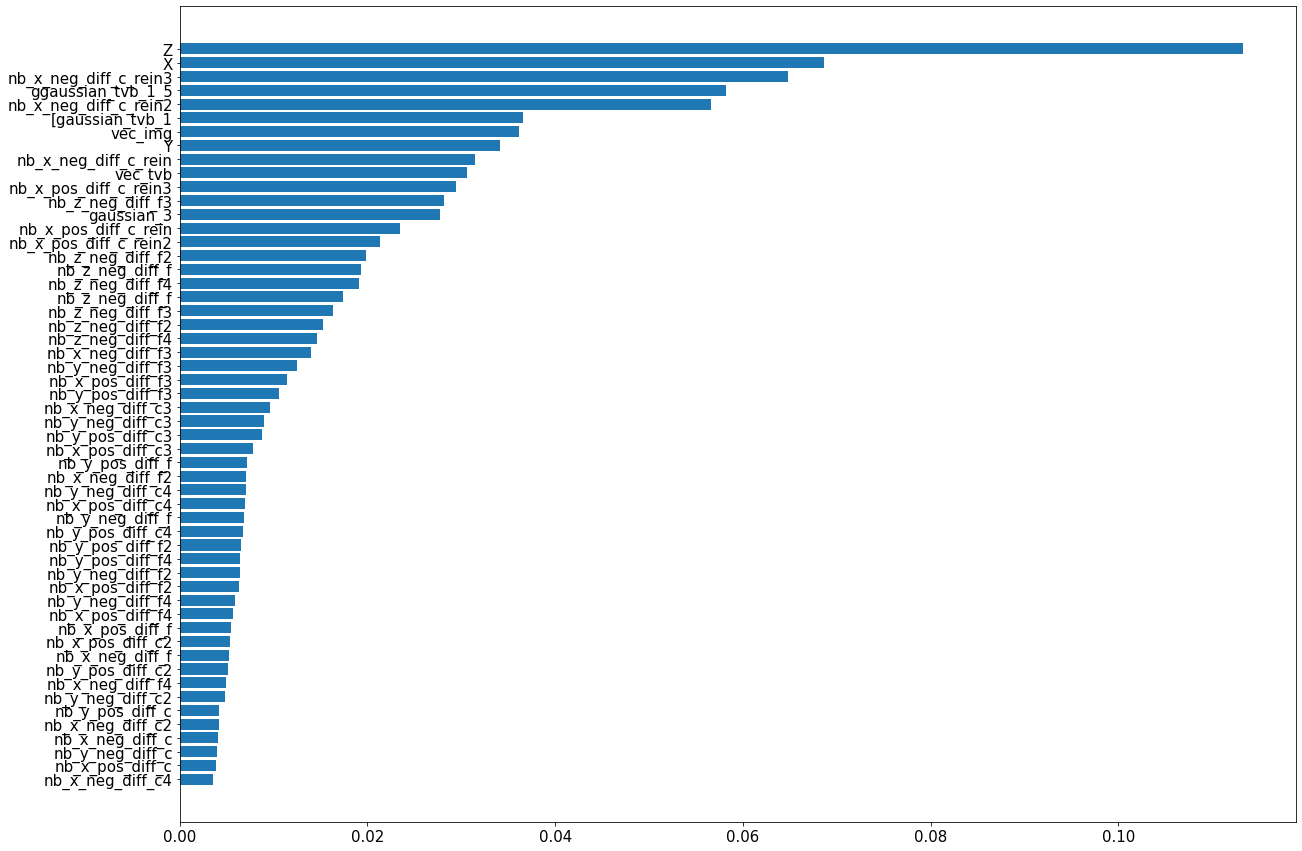

In [62]:
importances = clf.feature_importances_
idx_sort = np.argsort(importances)

height = importances[idx_sort]
bars = features_names[idx_sort]
y_pos = np.arange(len(bars))

fig, ax = plt.subplots(1,1,figsize=(20,15)) 
ax.barh(y_pos, height)
ax.set_yticks(y_pos)
ax.set_yticklabels(bars)
plt.show()

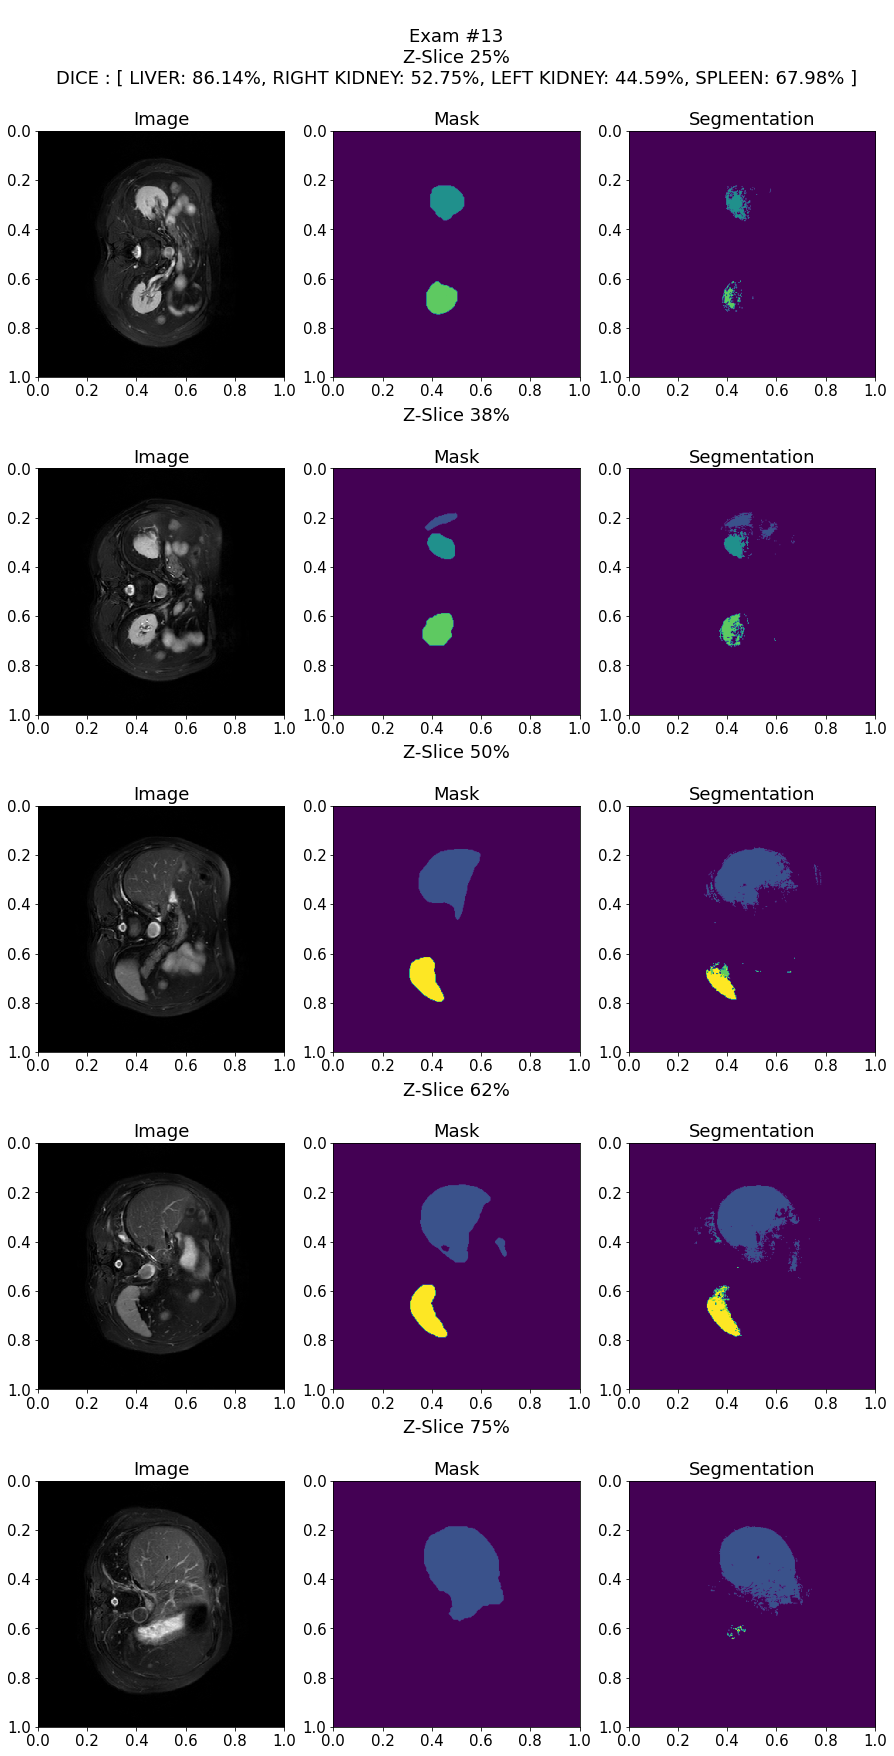

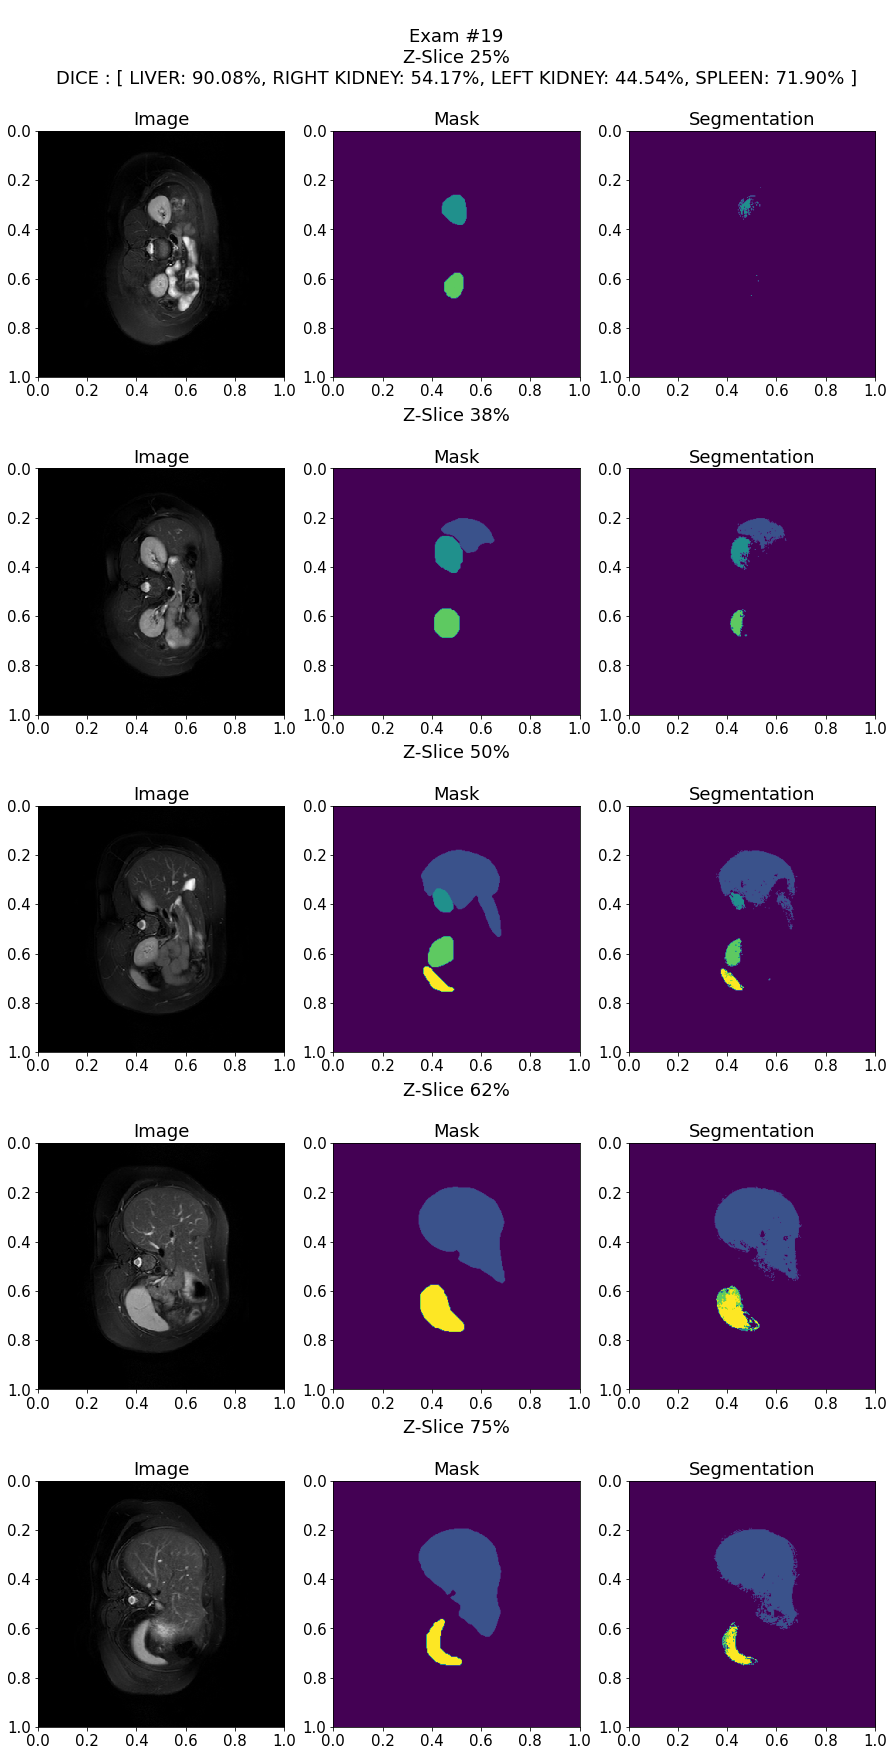

In [63]:
test_model(scaler, clf)